In [1]:
import pandas as pd
import numpy as np
import os
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

# Load the dataset
file_path = 'sunspot.csv'
df = pd.read_csv(file_path)
df.head()

,Year,Month,Day,Date In Fraction Of Year,Number of Sunspots,Standard Deviation,Observations,Indicator
0,1818,1,1,1818.001,-1,-1.0,0,1
1,1818,1,2,1818.004,-1,-1.0,0,1
2,1818,1,3,1818.007,-1,-1.0,0,1
3,1818,1,4,1818.010,-1,-1.0,0,1
4,1818,1,5,1818.012,-1,-1.0,0,1


In [2]:
df.isnull().sum()

Year                        0
Month                       0
Day                         0
Date In Fraction Of Year    0
Number of Sunspots          0
Standard Deviation          0
Observations                0
Indicator                   0
dtype: int64

In [3]:
# Create date column from Year, Month and Day columns
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']].assign(
    Year=df['Year'],
    Month=df['Month'],
    Day=df['Day']
))
df.head()

,Year,Month,Day,Date In Fraction Of Year,Number of Sunspots,Standard Deviation,Observations,Indicator,Date
0,1818,1,1,1818.001,-1,-1.0,0,1,1818-01-01
1,1818,1,2,1818.004,-1,-1.0,0,1,1818-01-02
2,1818,1,3,1818.007,-1,-1.0,0,1,1818-01-03
3,1818,1,4,1818.010,-1,-1.0,0,1,1818-01-04
4,1818,1,5,1818.012,-1,-1.0,0,1,1818-01-05


In [4]:
df1 = df.reset_index()['Number of Sunspots']

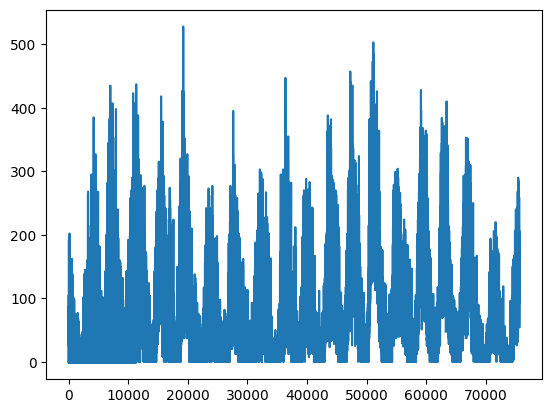

In [5]:
plt.plot(df1)

In [6]:
from tensorflow.keras.layers import Input # type: ignore

scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

# Split sequence data into training and testing sets (65/35 split)
train_size = int(len(df1)*0.7)
test_size = len(df1)-train_size
train_data,test_data = df1[0:train_size,:],df1[train_size:len(df1),:1]

In [7]:
train_size, test_size

(52965, 22700)

In [8]:
# Convert an array of values into a dataset matrix
def create_dataset(dataset, timesteps=1):
  X, Y = [], []
  for i in range(len(dataset)-timesteps-1):
    a = dataset[i:(i+timesteps), 0]
    X.append(a)
    Y.append(dataset[i + timesteps, 0])
  return np.array(X), np.array(Y)

timesteps = 4380 *2
X_train, y_train = create_dataset(train_data, timesteps)
X_test, y_test = create_dataset(test_data, timesteps)

In [9]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((44204, 8760), (13939, 8760), (44204,), (13939,))

In [10]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [12]:
# Build the LSTM model
model = Sequential()
model.add(Input(shape=(X_train.shape[1], 1)))
model.add(LSTM(50, activation='tanh', return_sequences=True))
model.add(LSTM(50, activation='tanh'))
model.add(Dense(1))

# Compile the model with Adam optimizer with a learning rate of 0.001
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 8760, 50)       │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Train the model
history = model.fit(X_train, y_train, epochs=5,
                    batch_size=32, verbose=1,
                    validation_data=(X_test, y_test))

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform the predictions and actual values
train_predict = scaler.inverse_transform(np.concatenate((train_predict,
                                                         np.zeros((len(train_predict),1))),
                                                        axis=1))[:,0]
y_train = scaler.inverse_transform(np.concatenate((y_train.reshape(-1,1),
                                                   np.zeros((len(y_train),1))),
                                                  axis=1))[:,0]

test_predict = scaler.inverse_transform(np.concatenate((test_predict,
                                                        np.zeros((len(test_predict),1))),
                                                       axis=1))[:,0]
y_test = scaler.inverse_transform(np.concatenate((y_test.reshape(-1,1),
                                                  np.zeros((len(y_test),1))),
                                                 axis=1))[:,0]

Epoch 1/5
1382/1382 ━━━━━━━━━━━━━━━━━━━━ 647s 466ms/step - loss: 0.0051 - val_loss: 9.9168e-04
Epoch 2/5
1382/1382 ━━━━━━━━━━━━━━━━━━━━ 634s 459ms/step - loss: 0.0030 - val_loss: 8.5070e-04
Epoch 3/5
1382/1382 ━━━━━━━━━━━━━━━━━━━━ 682s 459ms/step - loss: 0.0029 - val_loss: 9.0013e-04
Epoch 4/5
1382/1382 ━━━━━━━━━━━━━━━━━━━━ 682s 459ms/step - loss: 0.0028 - val_loss: 9.6471e-04
Epoch 5/5
1382/1382 ━━━━━━━━━━━━━━━━━━━━ 682s 459ms/step - loss: 0.0029 - val_loss: 9.7182e-04
1382/1382 ━━━━━━━━━━━━━━━━━━━━ 246s 177ms/step
436/436 ━━━━━━━━━━━━━━━━━━━━ 78s 178ms/step


In [14]:
# Evaluate the model
lstm_mse = mean_squared_error(y_test, test_predict)
lstm_rmse = np.sqrt(lstm_mse)
lstm_mae = mean_absolute_error(y_test, test_predict)
lstm_r2 = r2_score(y_test, test_predict)

print("LSTM Model Performance:")
print("Test MSE:", lstm_mse)
print("Test RMSE:", lstm_rmse)
print("Test MAE:", lstm_mae)
print("Test R2:", lstm_r2)

LSTM Model Performance:
Test MSE: 271.9557040167728
Test RMSE: 16.491079528544297
Test MAE: 11.606099774931257
Test R2: 0.9489477436644612


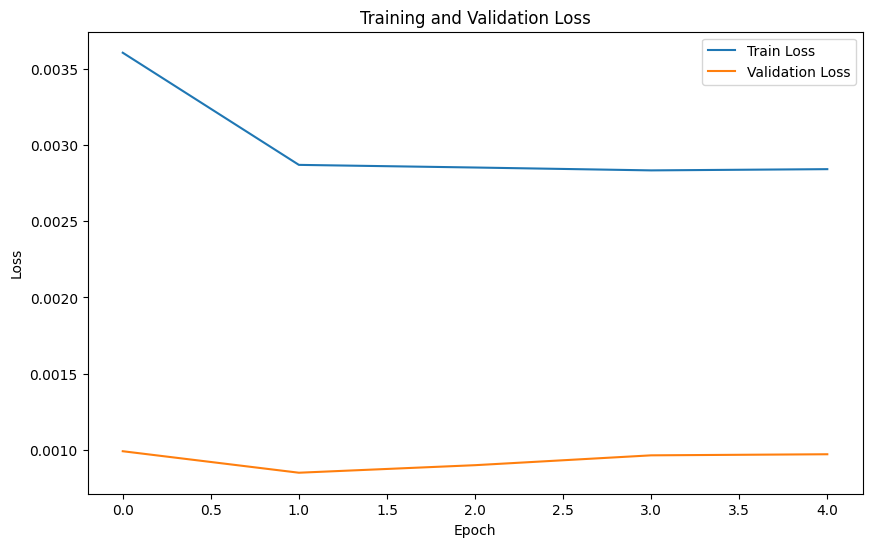

In [15]:
# Plot validation loss and train loss
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

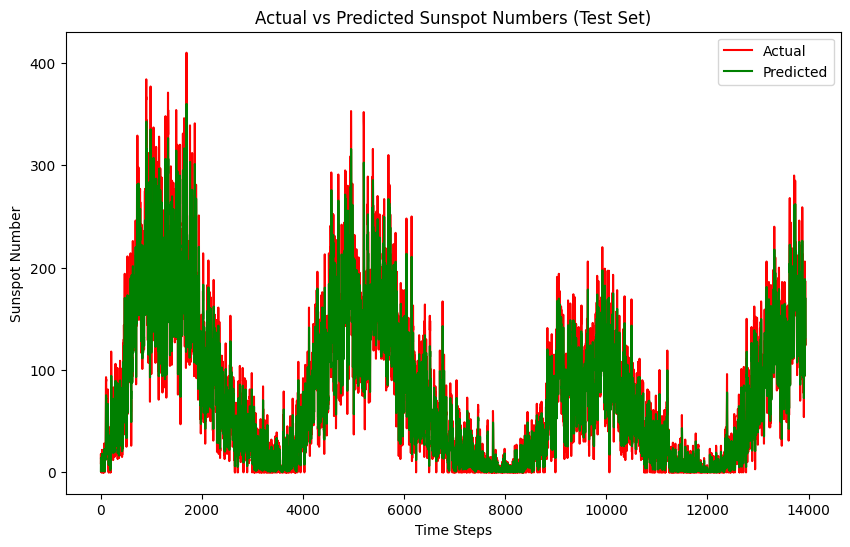

In [16]:
# Plot actual vs predicted values for the test set
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual', color = 'red')
plt.plot(test_predict, label='Predicted', color = 'green')
plt.xlabel('Time Steps')
plt.ylabel('Sunspot Number')
plt.title('Actual vs Predicted Sunspot Numbers (Test Set)')
plt.legend()
plt.show()

In [17]:
len(train_predict), len(test_predict)

(44204, 13939)

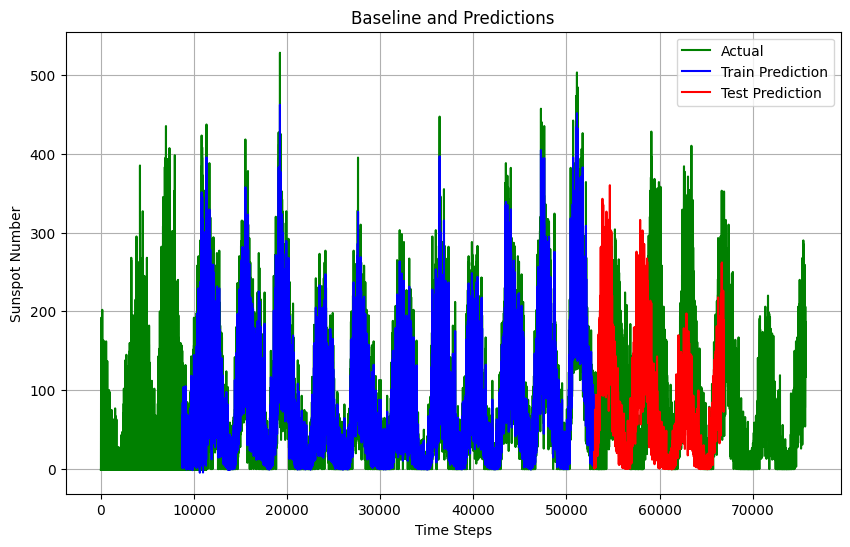

In [18]:
# Plotting shift train predictions for plotting
look_back = 4380 * 2
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict) + look_back, 0] = train_predict

# Shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan

# Calculate the correct starting index for test predictions to avoid overlap
start_index = len(train_predict) + look_back + 1

# Adjust end_index to ensure it's within the bounds of data_scaled
end_index = min(start_index + len(test_predict), len(df1) - 1)

# Check if the slice is valid before assigning
if end_index > start_index:
    # Assign test predictions only if the slice has a positive length
    valid_len = min(len(test_predict), end_index - start_index)
    testPredictPlot[start_index:start_index + valid_len, 0] = test_predict[:valid_len]
else:
    # Adjust test predictions slice if it's empty: recompute indices to ensure a valid slice
    if start_index >= len(df1) - 1:
        start_index = max(len(df1) - len(test_predict), 0)
    end_index = start_index + len(test_predict)
    if end_index > len(df1):
        end_index = len(df1)
        start_index = end_index - len(test_predict)
    testPredictPlot[start_index:end_index, 0] = test_predict[:end_index - start_index]

# Plot baseline and predictions
plt.figure(figsize=(10, 6))
plt.plot(scaler.inverse_transform(df1)[:, 0], label='Actual', color='green')
plt.plot(trainPredictPlot[:, 0], label='Train Prediction', color='blue')
plt.plot(testPredictPlot[:, 0], label='Test Prediction', color='red')
plt.xlabel('Time Steps')
plt.ylabel('Sunspot Number')
plt.title('Baseline and Predictions')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
len(test_data)

22700

In [21]:
x_input=test_data[8760:].reshape(1, -1)
x_input.shape

(1, 13940)

In [22]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [24]:
lst_output = []
n_steps = 13940
i = 0
n_future = 8760

while i < n_future:
    if len(temp_input) > n_steps:
        x_input = np.array(temp_input[1:])
        # print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        # print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        # print(temp_input)
        lst_output.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i = i + 1

Streaming output truncated to the last 5000 lines.
3760 day output [[0.]]
3761 day output [[0.]]
3762 day output [[0.]]
3763 day output [[0.]]
3764 day output [[0.]]
3765 day output [[0.]]
3766 day output [[0.]]
3767 day output [[0.]]
3768 day output [[0.]]
3769 day output [[0.]]
3770 day output [[0.]]
3771 day output [[0.]]
3772 day output [[0.]]
3773 day output [[0.]]
3774 day output [[0.]]
3775 day output [[0.]]
3776 day output [[0.]]
3777 day output [[0.]]
3778 day output [[0.]]
3779 day output [[0.]]
3780 day output [[0.]]
3781 day output [[0.]]
3782 day output [[0.]]
3783 day output [[0.]]
3784 day output [[0.]]
3785 day output [[0.]]
3786 day output [[0.]]
3787 day output [[0.]]
3788 day output [[0.]]
3789 day output [[0.]]
3790 day output [[0.]]
3791 day output [[0.]]
3792 day output [[0.]]
3793 day output [[0.]]
3794 day output [[0.]]
3795 day output [[0.]]
3796 day output [[0.]]
3797 day output [[0.]]
3798 day output [[0.]]
3799 day output [[0.]]
3800 day output [[0.]]
3801 d

In [27]:
# Parameters
lst_output = []
n_steps = 13940  # lookback window for LSTM
n_future = 8760  # number of future points to predict

# Predict future values one by one
for i in range(n_future):
    if len(temp_input) > n_steps:
        x_input = np.array(temp_input[-n_steps:])
    else:
        x_input = np.array(temp_input)
        x_input = np.pad(x_input, (n_steps - len(x_input), 0), mode='constant')

    x_input = x_input.reshape((1, n_steps, 1))
    yhat = model.predict(x_input, verbose=0)
    temp_input.append(yhat[0][0])
    lst_output.append(yhat[0][0])

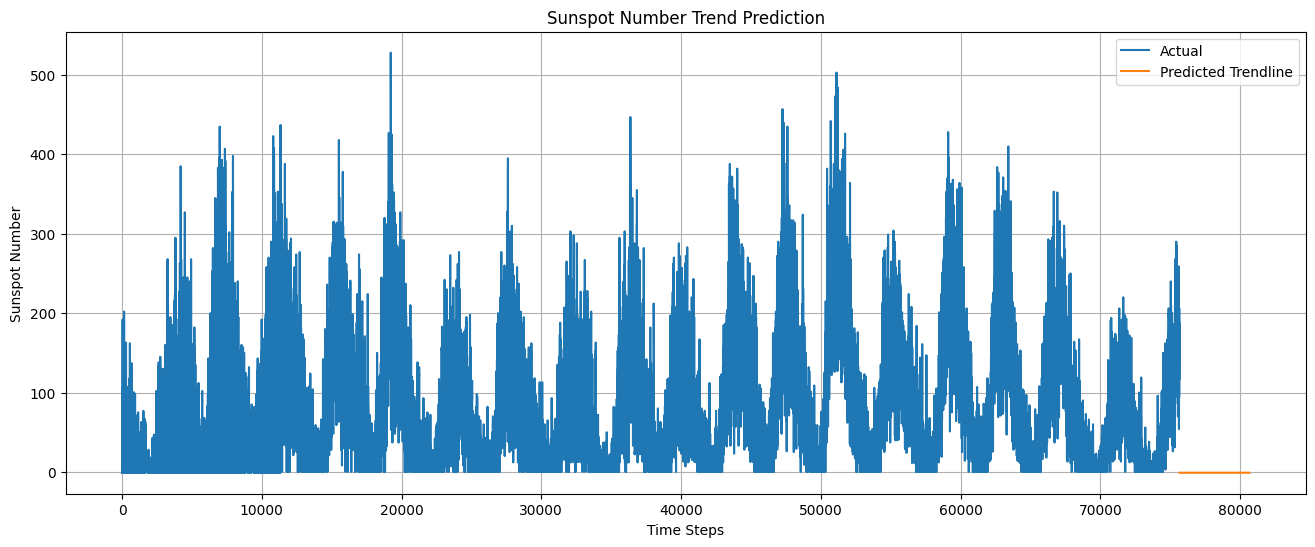

In [28]:
# Combine actual + predicted for plotting
original_len = len(df1)
df3 = df1.tolist()
df3.extend(np.array(lst_output).reshape(-1, 1))

# Create time steps
full_time = np.arange(0, len(df3))

# Plot actual and predicted trendlines
plt.figure(figsize=(16, 6))
plt.plot(full_time[:original_len], scaler.inverse_transform(df1), label='Actual')
plt.plot(full_time[original_len:], scaler.inverse_transform(np.array(lst_output).reshape(-1, 1)), label='Predicted Trendline')
plt.xlabel('Time Steps')
plt.ylabel('Sunspot Number')
plt.title('Sunspot Number Trend Prediction')
plt.legend()
plt.grid(True)
plt.show()

15:27:48 - cmdstanpy - INFO - Chain [1] start processing
15:28:32 - cmdstanpy - INFO - Chain [1] done processing


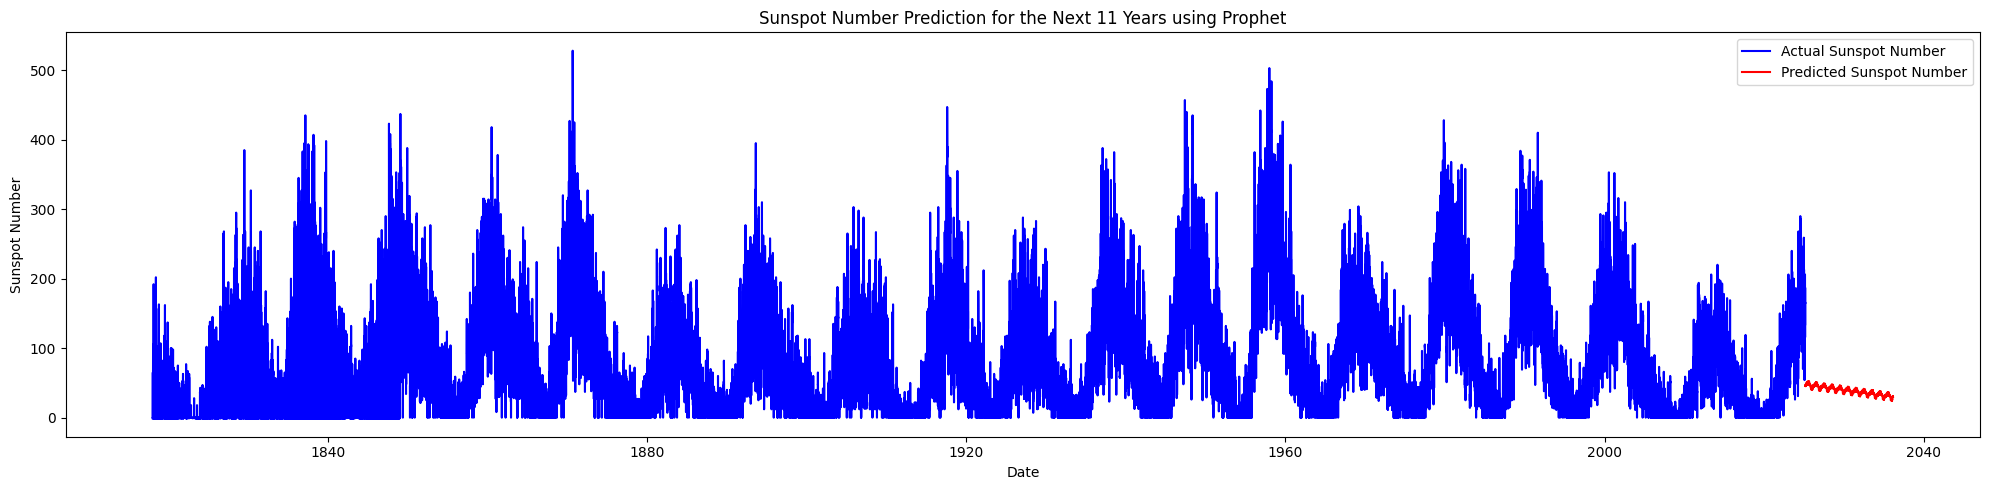

In [11]:
df_prophet = df[['Year', 'Month', 'Day', 'Number of Sunspots']].copy()
df_prophet['Date'] = pd.to_datetime(df_prophet[['Year', 'Month', 'Day']])  # Create 'Date' column
df_prophet = df_prophet[['Date', 'Number of Sunspots']].rename(
    columns={'Date': 'ds', 'Number of Sunspots': 'y'})

from prophet import Prophet

# Prepare the data for Prophet
df_prophet = df_prophet[['ds', 'y']]  # Use df_prophet instead of df

# Initialize the Prophet model
model_prophet = Prophet()

# Fit the model
model_prophet.fit(df_prophet)

# Make future dataframe for 11 years
future = model_prophet.make_future_dataframe(periods=4017)

# Predict the future
forecast = model_prophet.predict(future)

# Plot the actual and predicted values
plt.figure(figsize=(20, 5))

# Plot actual values from the original dataframe up to the last date in the original data
plt.plot(df_prophet['ds'], df_prophet['y'], label='Actual Sunspot Number', color='blue')

# Plot predicted values starting from the day after the last date in the original data
plt.plot(forecast['ds'][df_prophet.shape[0]:], forecast['yhat'][df_prophet.shape[0]:],
         label='Predicted Sunspot Number', color='red')

# Set plot title and labels
plt.title('Sunspot Number Prediction for the Next 11 Years using Prophet')
plt.xlabel('Date')
plt.ylabel('Sunspot Number')

# Add legend
plt.legend()
plt.tight_layout()
# Show plot
plt.show()

In [12]:
from sklearn.metrics import explained_variance_score # import the missing function

def mean_absolute_scaled_error(y_true, y_pred, y_train, mae_train):
    n = len(y_true)
    d = np.abs(np.diff(y_train)).sum() / (len(y_train) - 1)
    errors = np.abs(y_true - y_pred)
    return errors.mean() / d

# Calculate the Mean Squared Error (MSE) for Prophet
mse_prophet = mean_squared_error(df_prophet['y'], forecast['yhat'][:df_prophet.shape[0]])
print('Mean Squared Error (MSE) for Prophet:', mse_prophet)

# Calculate the Mean Absolute Error (MAE) for Prophet
mae_prophet = mean_absolute_error(df_prophet['y'], forecast['yhat'][:df_prophet.shape[0]])
print('Mean Absolute Error (MAE) for Prophet:', mae_prophet)

# Calculate the Root Mean Squared Error (RMSE) for Prophet
rmse_prophet = np.sqrt(mse_prophet)
print('Root Mean Squared Error (RMSE) for Prophet:', rmse_prophet)

# Calculate the Mean Absolute Scaled Error (MASE) for Prophet
mase_prophet = mean_absolute_scaled_error(df_prophet['y'], forecast['yhat'][:df_prophet.shape[0]],
                                          df_prophet['y'].shift(1).dropna(), mae_prophet)
print('Mean Absolute Scaled Error (MASE) for Prophet:', mase_prophet)

# Calculate the R-squared value for Prophet
r2_prophet = r2_score(df_prophet['y'], forecast['yhat'][:df_prophet.shape[0]])
print('R-squared value for Prophet:', r2_prophet)

# Calculate the Explained Variance Score for Prophet
evs_prophet = explained_variance_score(df_prophet['y'], forecast['yhat'][:df_prophet.shape[0]])
print('Explained Variance Score for Prophet:', evs_prophet)

Mean Squared Error (MSE) for Prophet: 5081.905283032244
Mean Absolute Error (MAE) for Prophet: 57.09709439419551
Root Mean Squared Error (RMSE) for Prophet: 71.2874833545991
Mean Absolute Scaled Error (MASE) for Prophet: 3.2675809953461257
R-squared value for Prophet: 0.1476005202079712
Explained Variance Score for Prophet: 0.1476005202952123


In [13]:
from statsmodels.tsa.arima.model import ARIMA

import matplotlib.pyplot as plt

# Prepare the data for ARIMA
# Use the 'Number of Sunspots' column as the time series data
time_series_data = df['Number of Sunspots']

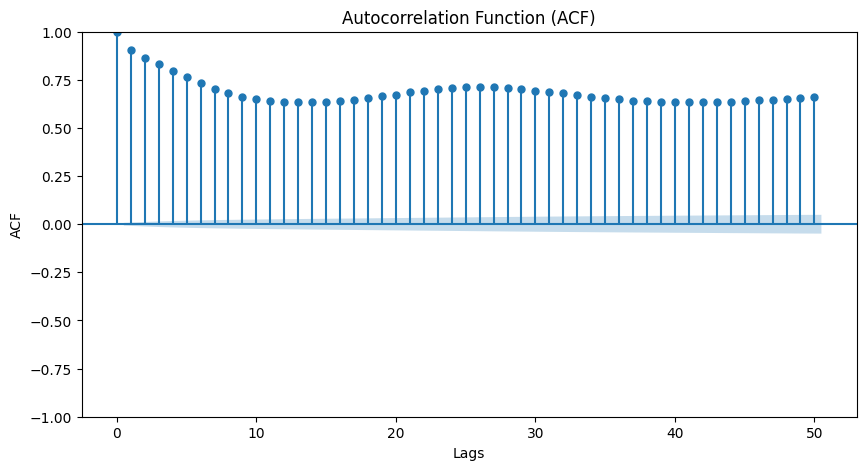

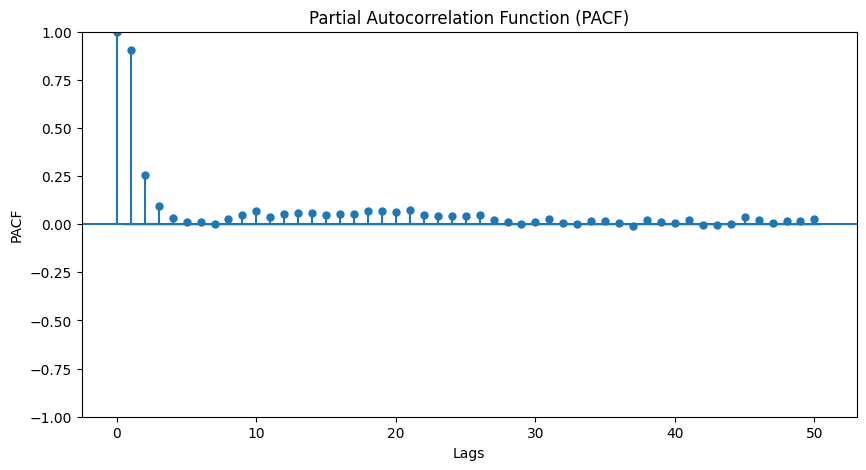

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF
plt.figure(figsize=(10, 5))
plot_acf(time_series_data, lags=50, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lags')
plt.ylabel('ACF')
plt.show()

# Plot PACF
plt.figure(figsize=(10, 5))
plot_pacf(time_series_data, lags=50, ax=plt.gca(), method='ywm')
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lags')
plt.ylabel('PACF')
plt.show()

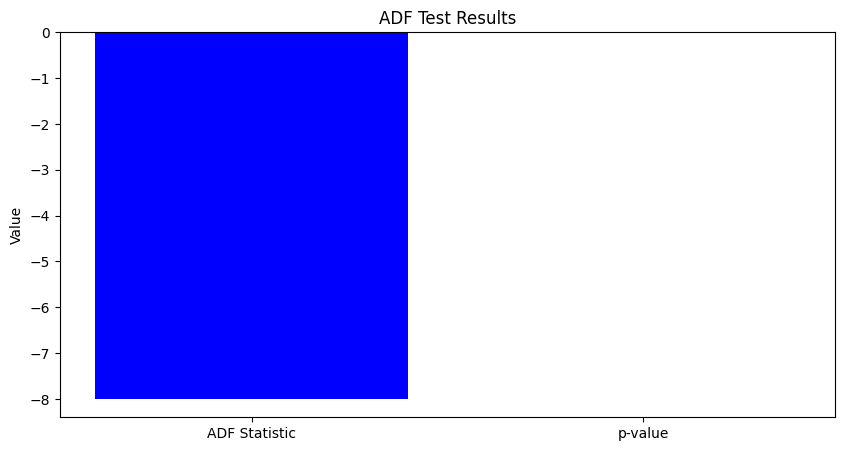

ADF Statistic: -7.999759024543343
p-value: 2.3511572436168886e-12


In [15]:
from statsmodels.tsa.stattools import adfuller

import matplotlib.pyplot as plt

# Perform the ADF test
adf_result = adfuller(time_series_data)

# Extract the test statistic and p-value
adf_statistic = adf_result[0]
p_value = adf_result[1]

# Plot the ADF test results
plt.figure(figsize=(10, 5))
plt.bar(['ADF Statistic', 'p-value'], [adf_statistic, p_value], color=['blue', 'orange'])
plt.title('ADF Test Results')
plt.ylabel('Value')
plt.show()

# Print the test results
print(f"ADF Statistic: {adf_statistic}")
print(f"p-value: {p_value}")

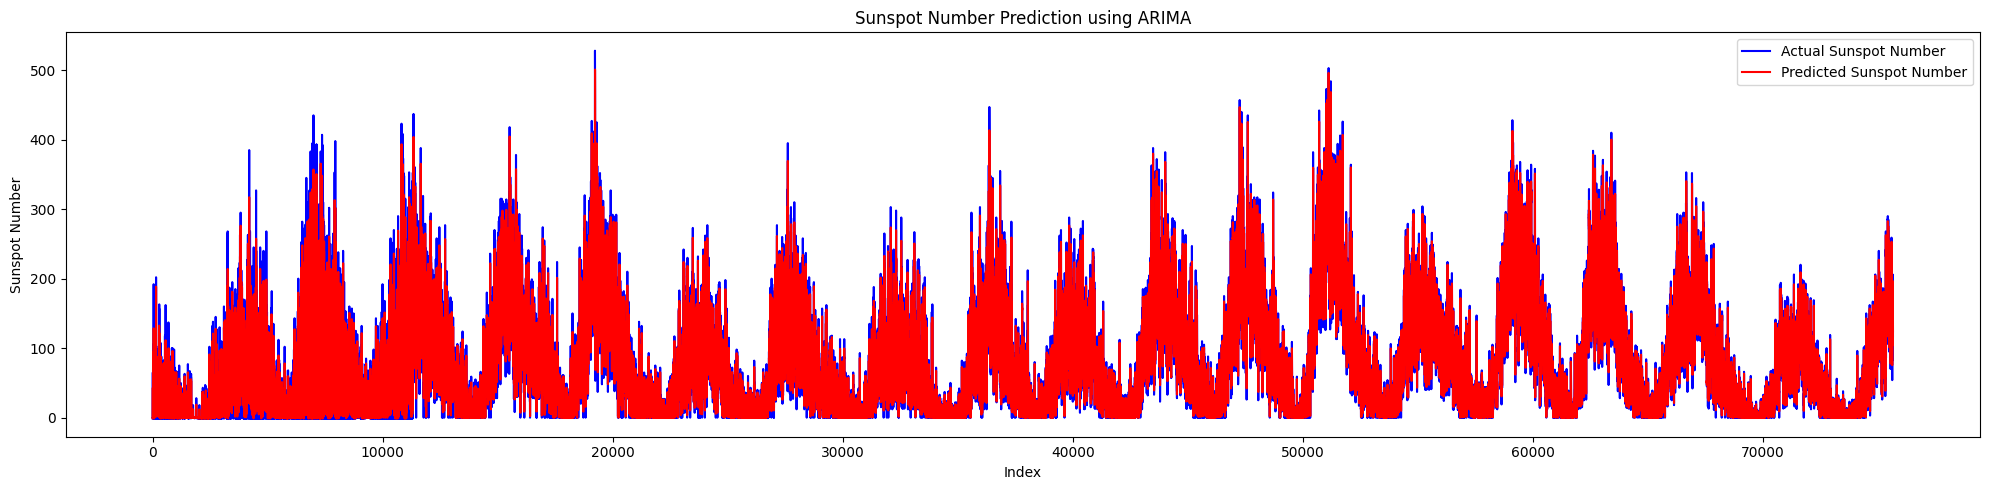

In [16]:
# Define the ARIMA model
model_arima = ARIMA(time_series_data, order=(5, 1, 0))

# Fit the ARIMA model
model_arima_fit = model_arima.fit()

# Make predictions
predictions_arima = model_arima_fit.predict(start=1, end=len(time_series_data))

# Plot the actual and predicted values
plt.figure(figsize=(20, 5))

# Plot actual values
# Use the index of the DataFrame as the x-axis instead of 'Date'
plt.plot(df.index, time_series_data, label='Actual Sunspot Number', color='blue')

# Plot predicted values
# Use the index of the DataFrame as the x-axis instead of 'Date'
plt.plot(df.index, predictions_arima, label='Predicted Sunspot Number', color='red')


# Set plot title and labels
plt.title('Sunspot Number Prediction using ARIMA')
plt.xlabel('Index') # Changed x-axis label to 'Index'
plt.ylabel('Sunspot Number')

# Add legend
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
# Print the ARIMA model summary
model_arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:     Number of Sunspots   No. Observations:                75665
Model:                 ARIMA(5, 1, 0)   Log Likelihood             -369335.954
Date:                Mon, 28 Apr 2025   AIC                         738683.908
Time:                        15:29:02   BIC                         738739.312
Sample:                             0   HQIC                        738700.935
                              - 75665                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3336      0.002   -211.515      0.000      -0.337      -0.330
ar.L2         -0.1427      0.002    -82.068      0.000      -0.146      -0.139
ar.L3         -0.0706      0.002    -40.355      0.000      -0.074      -0.067
ar.L4         -0.0433      0.002    -26.163      0.000      -0.047      -0.040
ar.L5         -0.0334      0.001    -23.672      0.000      -0.036      -0.031
sigma2      1017.1044      2.044    497.687      0.000    1013.099    1021.110
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):           1137497.70
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               0.17   Skew:                             0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

c:\Users\XT\AppData\Local\Programs\Python\Python312\genv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\XT\AppData\Local\Programs\Python\Python312\genv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


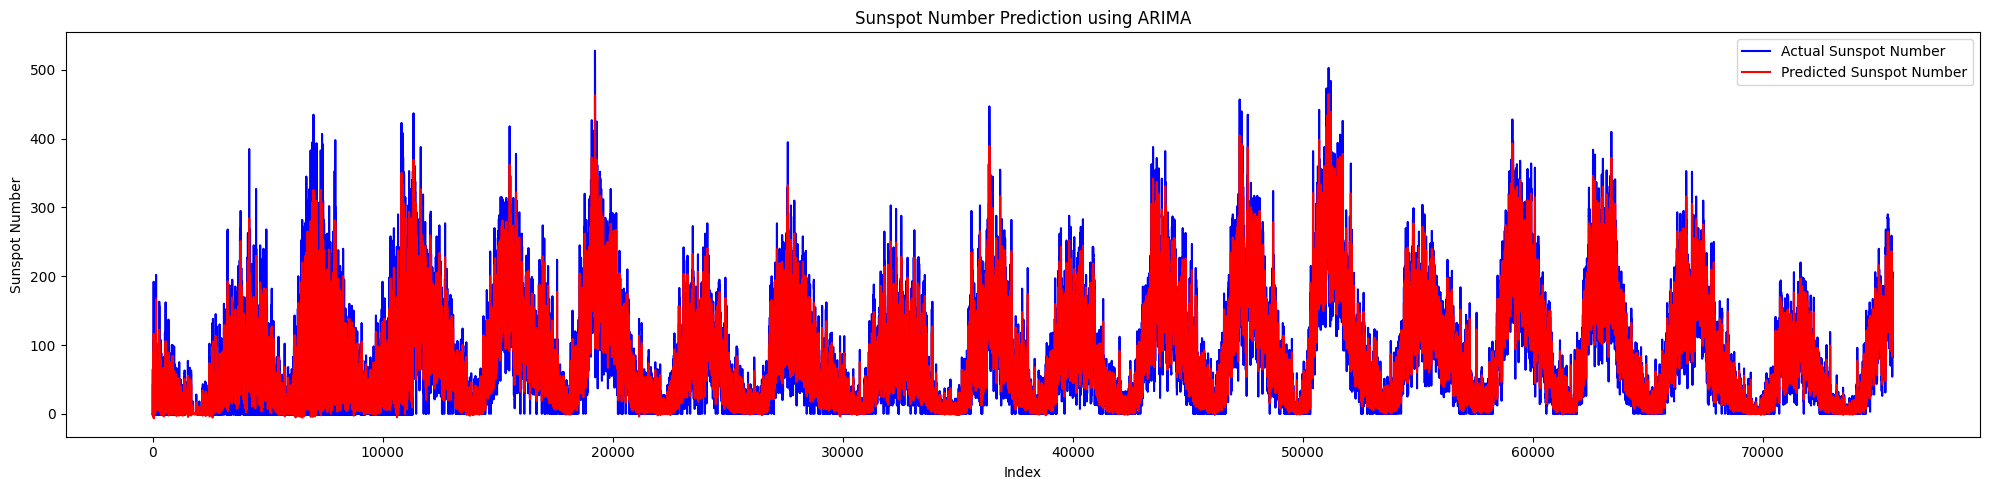

In [18]:
model_arima = ARIMA(time_series_data, order=(10, 1, 2))  # Changed order
# Fit the ARIMA model
model_arima_fit = model_arima.fit()

# Make predictions
predictions_arima = model_arima_fit.predict(start=1, end=len(time_series_data))

# Plot the actual and predicted values
plt.figure(figsize=(20, 5))

# Plot actual values
# Use the index of the DataFrame as the x-axis instead of 'Date'
plt.plot(df.index, time_series_data, label='Actual Sunspot Number', color='blue')

# Plot predicted values
# Use the index of the DataFrame as the x-axis instead of 'Date'
plt.plot(df.index, predictions_arima, label='Predicted Sunspot Number', color='red')


# Set plot title and labels
plt.title('Sunspot Number Prediction using ARIMA')
plt.xlabel('Index') # Changed x-axis label to 'Index'
plt.ylabel('Sunspot Number')

# Add legend
plt.legend()
plt.tight_layout()
plt.show()

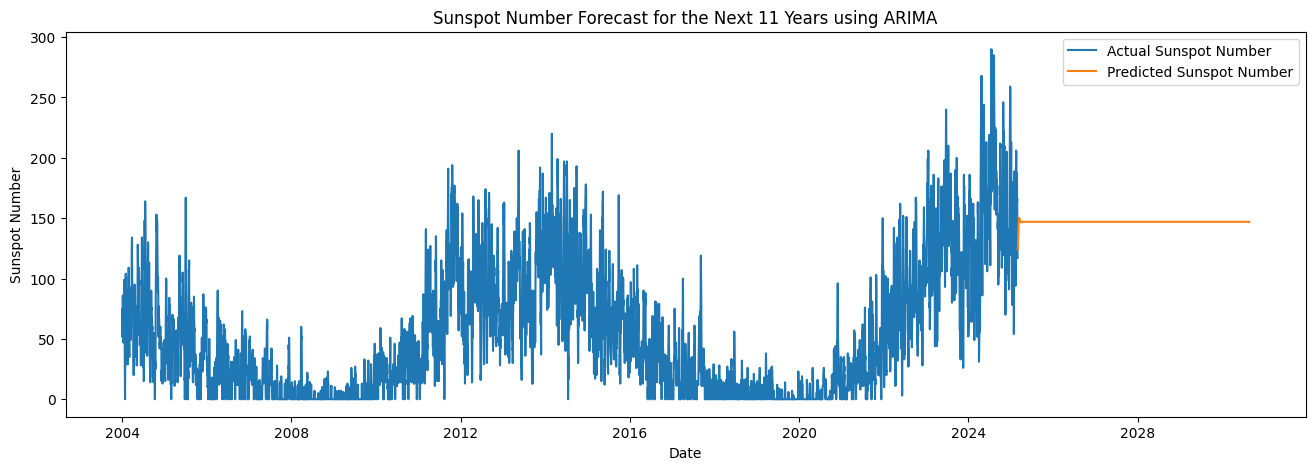

In [19]:
forecast_period_arima = 2000
forecast_arima_11_years = model_arima_fit.forecast(steps=forecast_period_arima)

# Assuming 'df' has columns 'Year', 'Month', 'Day'
# Create a 'Date' column if it doesn't exist
if 'Date' not in df.columns:
    df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])

# Create a date range for the future predictions
last_date = df['Date'].iloc[-1]
future_dates_arima_11_years = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_period_arima)

# Filter the original data to include only dates from 2004 onwards
filtered_df_arima = df[df['Date'] >= '2004-01-01']

# Create the DataFrame for future predictions
future_df_arima_11_years = pd.DataFrame(
    {'Predicted Sunspot Number': forecast_arima_11_years.values},
    index=future_dates_arima_11_years
)

# Plot the future forecast using seaborn
plt.figure(figsize=(16, 5))
sns.lineplot(x=filtered_df_arima['Date'], y=filtered_df_arima['Number of Sunspots'], label='Actual Sunspot Number')
sns.lineplot(x=future_df_arima_11_years.index, y=future_df_arima_11_years['Predicted Sunspot Number'], label='Predicted Sunspot Number')
plt.title('Sunspot Number Forecast for the Next 11 Years using ARIMA')
plt.xlabel('Date')
plt.ylabel('Sunspot Number')
plt.legend()
plt.show()

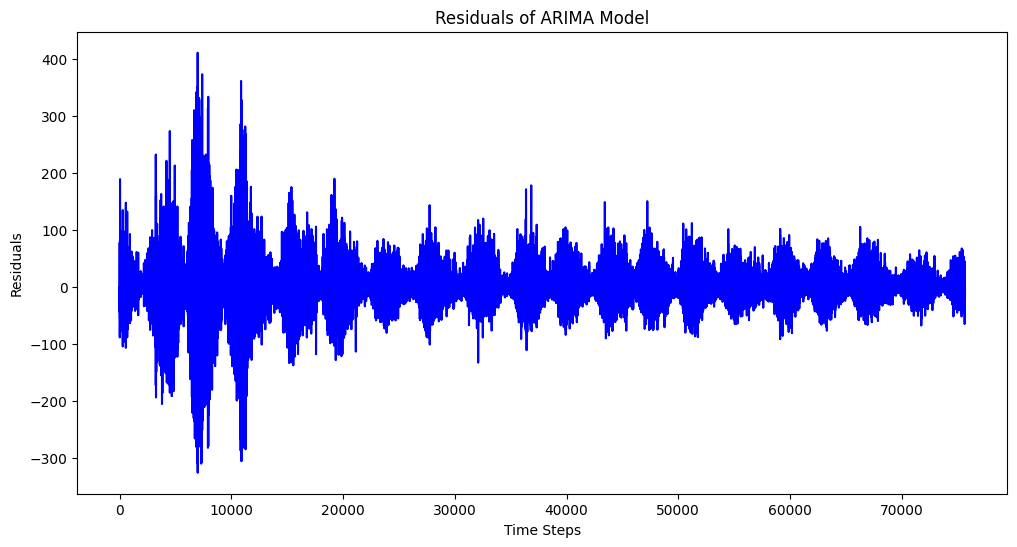

In [20]:
import warnings
warnings.filterwarnings('ignore')
# Define residuals using the ARIMA model's residuals
residuals = model_arima_fit.resid

# Plotting the residuals of ARIMA model
plt.figure(figsize=(12, 6))
plt.plot(residuals, color='blue')
plt.title('Residuals of ARIMA Model')
plt.xlabel('Time Steps')
plt.ylabel('Residuals')
plt.show()

In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Ensure predictions_arima has the same length as time_series_data[1:]
predictions_arima = predictions_arima[:len(time_series_data[1:])]

# Calculate Mean Absolute Error (MAE)
mae_arima = mean_absolute_error(time_series_data[1:], predictions_arima)
print(f"Mean Absolute Error (MAE) for ARIMA: {mae_arima}")

# Calculate Mean Squared Error (MSE)
mse_arima = mean_squared_error(time_series_data[1:], predictions_arima)
print(f"Mean Squared Error (MSE) for ARIMA: {mse_arima}")

# Calculate Root Mean Squared Error (RMSE)
rmse_arima = np.sqrt(mse_arima)
print(f"Root Mean Squared Error (RMSE) for ARIMA: {rmse_arima}")

# Calculate R-Squared
r2_arima = r2_score(time_series_data[1:], predictions_arima)
print(f"R-Squared for ARIMA: {r2_arima}")

# Calculate Mean Absolute Scaled Error (MASE)
def mean_absolute_scaled_error(y_true, y_pred, y_train):
    n = len(y_true)
    d = np.abs(np.diff(y_train)).sum() / (len(y_train) - 1)
    errors = np.abs(y_true - y_pred)
    return errors.mean() / d

# Ensure train_size is used from the previously defined variable
mase_arima = mean_absolute_scaled_error(time_series_data[1:], predictions_arima, time_series_data[:int(len(time_series_data) * 0.7)])
print(f"Mean Absolute Scaled Error (MASE) for ARIMA: {mase_arima}")

Mean Absolute Error (MAE) for ARIMA: 18.21970378689354
Mean Squared Error (MSE) for ARIMA: 944.4061383135559
Root Mean Squared Error (RMSE) for ARIMA: 30.73119161883502
R-Squared for ARIMA: 0.8415924513377724
Mean Absolute Scaled Error (MASE) for ARIMA: 0.8985780798031014


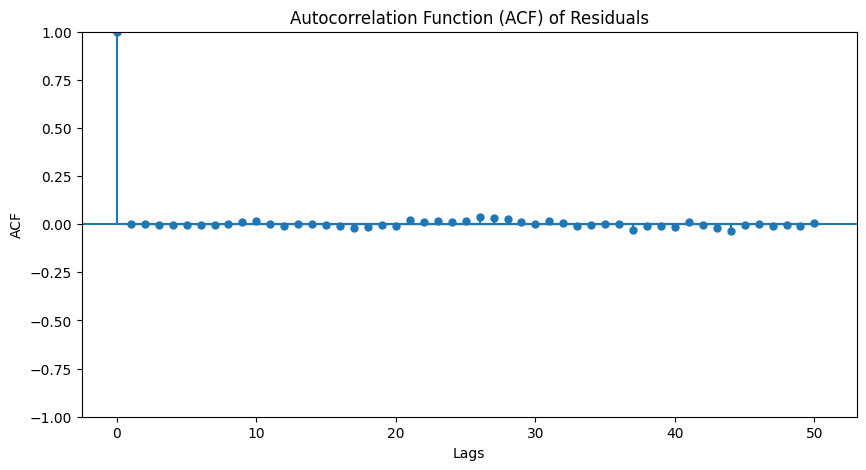

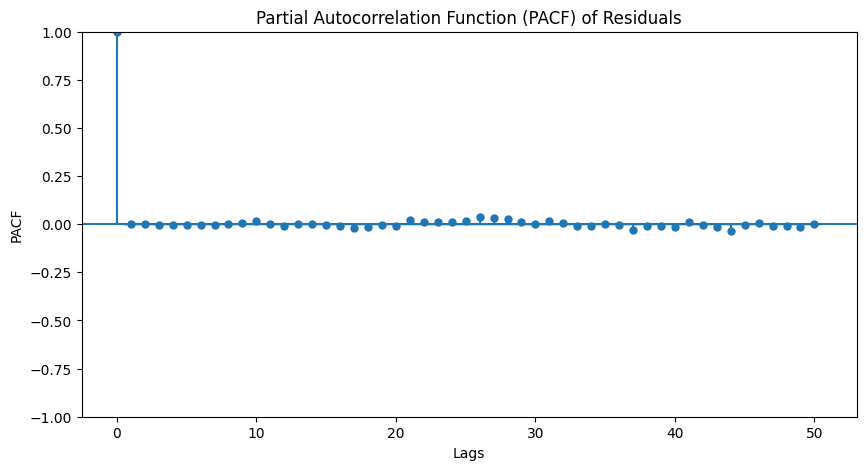

In [22]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF of residuals
plt.figure(figsize=(10, 5))
plot_acf(residuals, lags=50, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lags')
plt.ylabel('ACF')
plt.show()

# Plot PACF of residuals
plt.figure(figsize=(10, 5))
plot_pacf(residuals, lags=50, ax=plt.gca(), method='ywm')
plt.title('Partial Autocorrelation Function (PACF) of Residuals')
plt.xlabel('Lags')
plt.ylabel('PACF')
plt.show()

In [23]:
# !pip install statsmodels -q

# Using SARIMA model
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define the SARIMA model
model_sarima = SARIMAX(time_series_data, order=(5, 1, 0), seasonal_order=(1, 1, 1, 12))

# Fit the SARIMA model
model_sarima_fit = model_sarima.fit()

# Model Summary
model_sarima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                   Number of Sunspots   No. Observations:                75665
Model:             SARIMAX(5, 1, 0)x(1, 1, [1], 12)   Log Likelihood             -369220.066
Date:                              Mon, 28 Apr 2025   AIC                         738456.133
Time:                                      15:31:38   BIC                         738530.004
Sample:                                           0   HQIC                        738478.836
                                            - 75665                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3389      0.002   -215.476      0.000      -0.342      -0.336
ar.L2         -0.1480      0.002    -85.348      0.000      -0.151      -0.145
ar.L3         -0.0781      0.002    -44.482      0.000      -0.082      -0.075
ar.L4         -0.0507      0.002    -30.554      0.000      -0.054      -0.047
ar.L5         -0.0401      0.001    -28.491      0.000      -0.043      -0.037
ar.S.L12      -0.0544      0.001    -36.439      0.000      -0.057      -0.051
ma.S.L12      -0.9997      0.000  -3166.025      0.000      -1.000      -0.999
sigma2      1014.2120      2.056    493.372      0.000    1010.183    1018.241
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):           1128239.57
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               0.17   Skew:                             0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

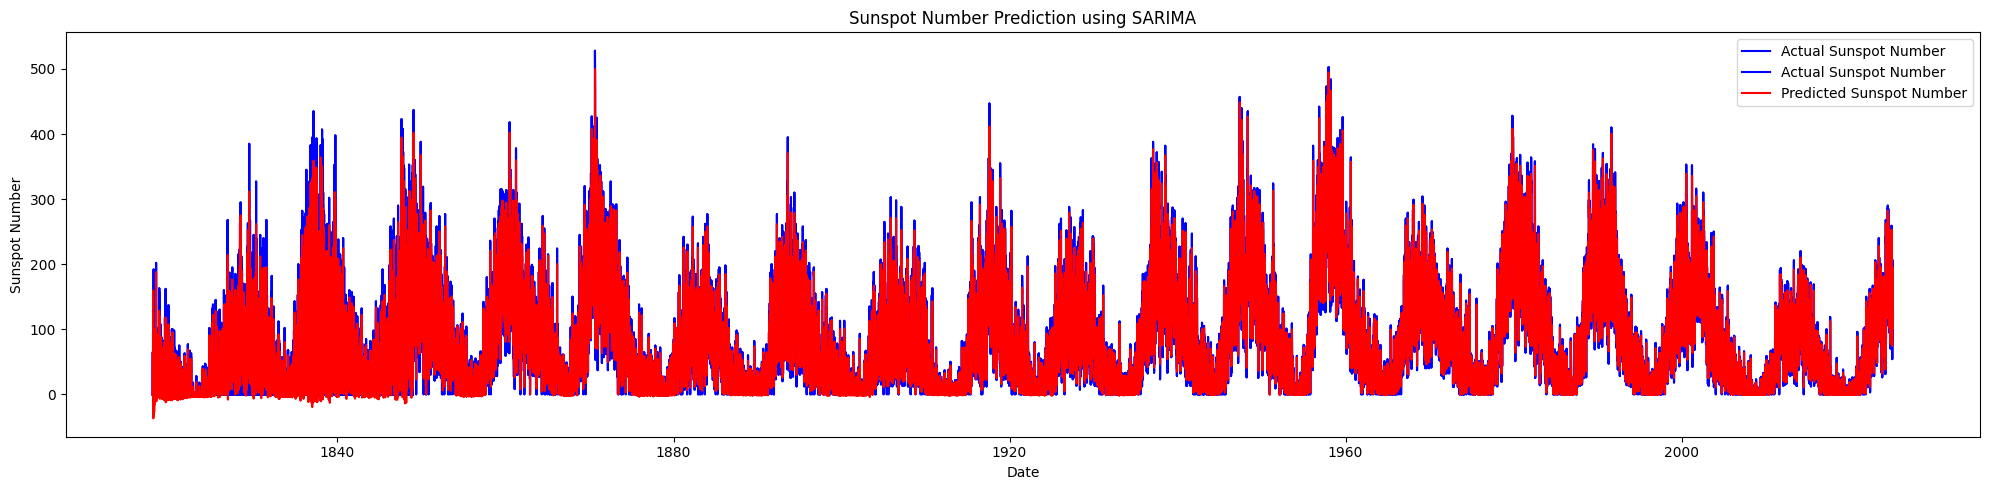

In [24]:
# Make predictions
predictions_sarima = model_sarima_fit.predict(start=1, end=len(time_series_data))

# Plot the actual and predicted values
plt.figure(figsize=(20, 5))

# Plot actual values based on 2004 and onwards
plt.plot(df['Date'], time_series_data, label='Actual Sunspot Number', color='blue')
plt.plot(df['Date'], time_series_data, label='Actual Sunspot Number', color='blue')

# Plot predicted values
plt.plot(df['Date'], predictions_sarima, label='Predicted Sunspot Number', color='red')

# Set plot title and labels
plt.title('Sunspot Number Prediction using SARIMA')
plt.xlabel('Date')
plt.ylabel('Sunspot Number')

# Add legend
plt.legend()
plt.tight_layout()
plt.show()

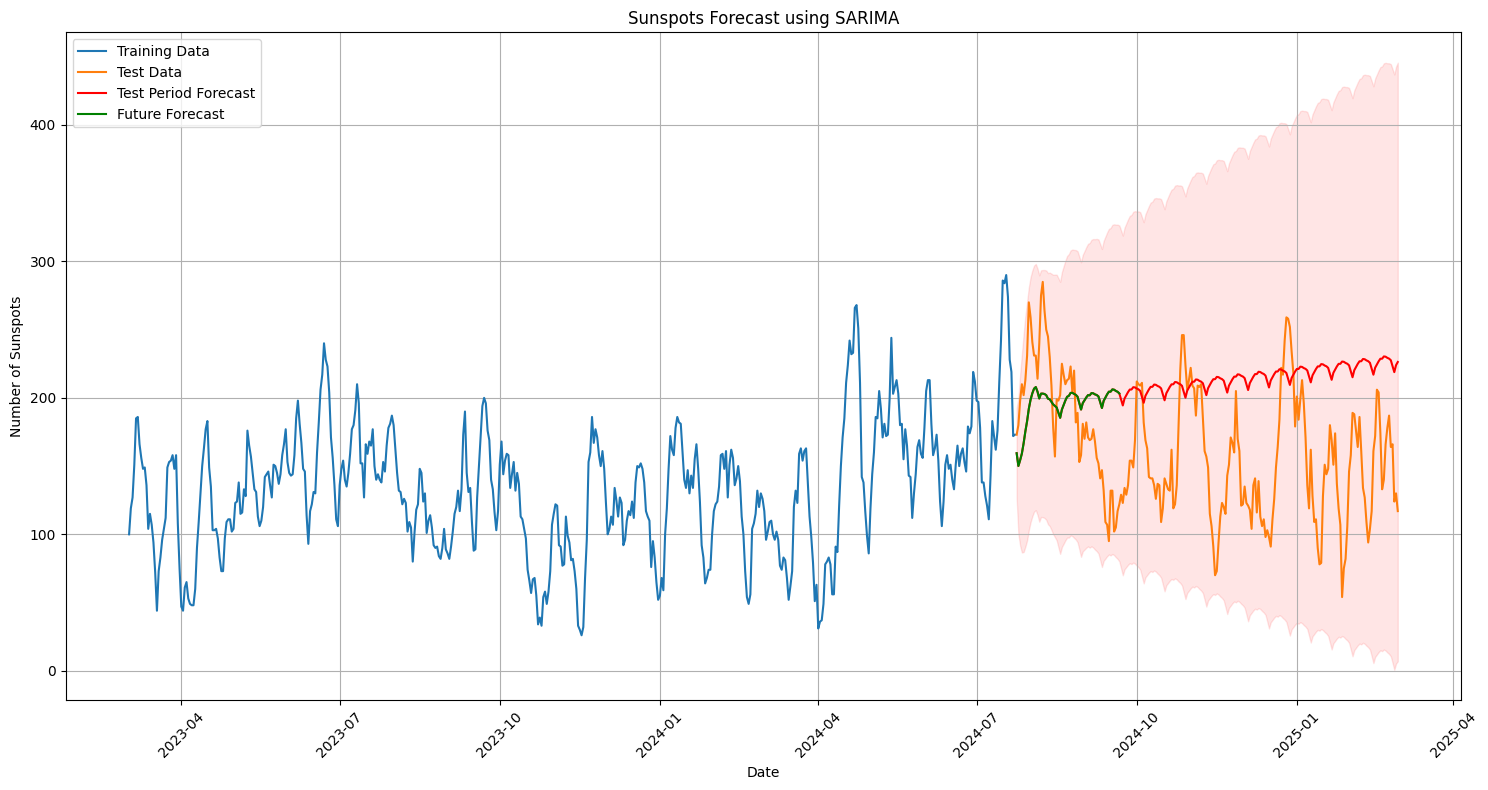

In [25]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

data = df.set_index('Date')['Number of Sunspots'].tail(365*2)
data.index = pd.DatetimeIndex(data.index, freq='D')

# Split the data into training (70%) and testing (30%) sets
train_size = int(len(data) * 0.7)
train_data = data[:train_size]
test_data = data[train_size:]

# Fit SARIMA model with parameters tuned for longer forecast
model = SARIMAX(train_data, 
                order=(2, 1, 2),
                seasonal_order=(1, 1, 1, 12),
                enforce_stationarity=False,
                enforce_invertibility=False)

# Add max_iter parameter and use method='nm' (Nelder-Mead) for better convergence
results = model.fit(disp=False, maxiter=1000, method='nm')

# Make forecast for the test period
forecast = results.get_forecast(steps=len(test_data))
forecast_mean = forecast.predicted_mean
forecast_conf = forecast.conf_int()

# Make future forecast for next 60 days
future_forecast = results.forecast(steps=60)


plt.figure(figsize=(15,8))
plt.plot(train_data.index, train_data, label='Training Data')
plt.plot(test_data.index, test_data, label='Test Data')
plt.plot(test_data.index, forecast_mean, label='Test Period Forecast', color='red')
plt.plot(future_forecast.index, future_forecast, label='Future Forecast', color='green')
plt.fill_between(forecast_mean.index,
                 forecast_conf.iloc[:, 0],
                 forecast_conf.iloc[:, 1], color='r', alpha=.1)
plt.title('Sunspots Forecast using SARIMA')
plt.xlabel('Date')
plt.ylabel('Number of Sunspots')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

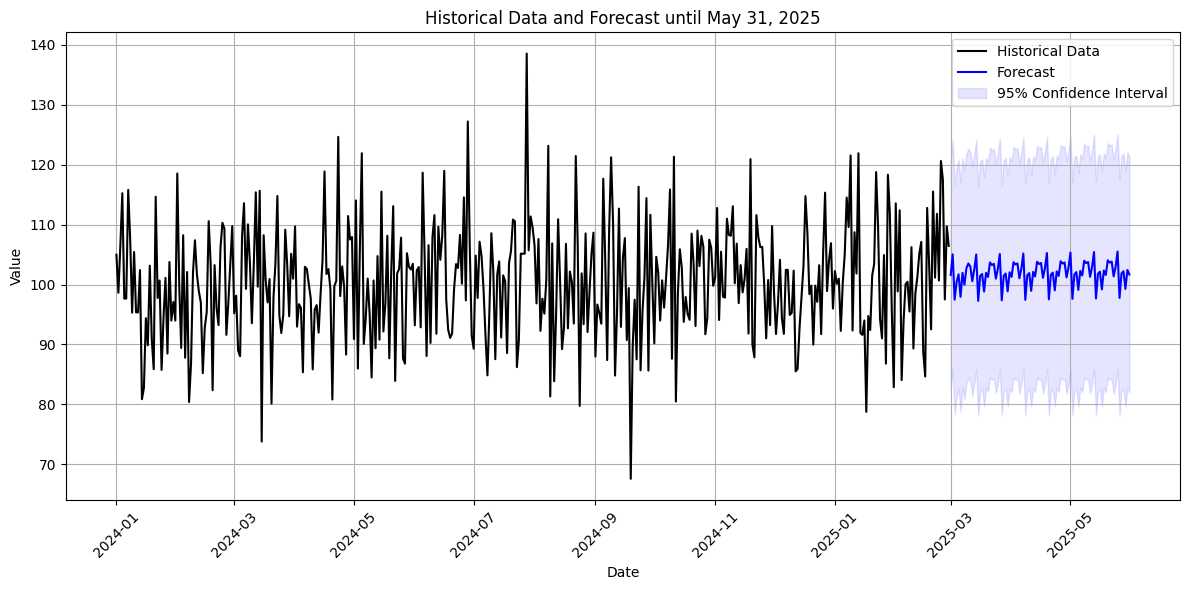

In [26]:
dates = pd.date_range(start='2024-01-01', end='2025-02-28', freq='D')
np.random.seed(42)
values = np.random.normal(100, 10, len(dates))
df = pd.DataFrame({'value': values}, index=dates)

# Create future dates for forecasting
last_date = pd.to_datetime('2025-02-28')
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1),
                           end='2025-05-31',
                           freq='D')

# Fit SARIMA model
# Note: Adjust the order and seasonal_order parameters based on your data
model = SARIMAX(df['value'],
                order=(1, 1, 1),
                seasonal_order=(1, 1, 1, 12))
results = model.fit()

# Generate forecast
forecast = results.get_forecast(steps=len(future_dates))
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Create forecast DataFrame
forecast_df = pd.DataFrame({
    'forecast': forecast_mean,
    'lower_ci': forecast_ci.iloc[:, 0],
    'upper_ci': forecast_ci.iloc[:, 1]
}, index=future_dates)


plt.figure(figsize=(12, 6))
# Plot historical data
plt.plot(df.index, df['value'], label='Historical Data', color='black')
# Plot forecast
plt.plot(forecast_df.index, forecast_df['forecast'], label='Forecast', color='blue')
plt.fill_between(forecast_df.index, 
                 forecast_df['lower_ci'],
                 forecast_df['upper_ci'],
                 color='blue', alpha=0.1, label='95% Confidence Interval')

plt.title('Historical Data and Forecast until May 31, 2025')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

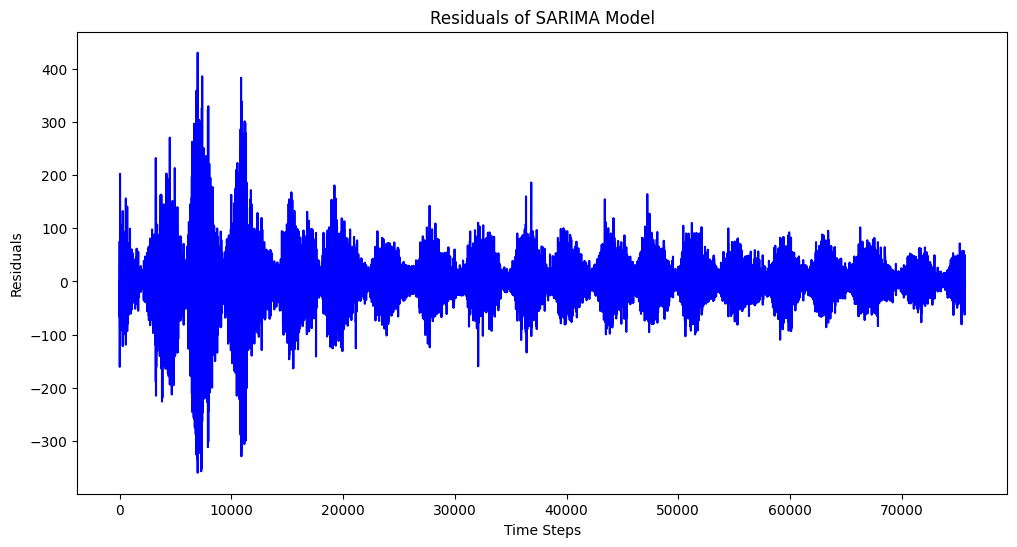

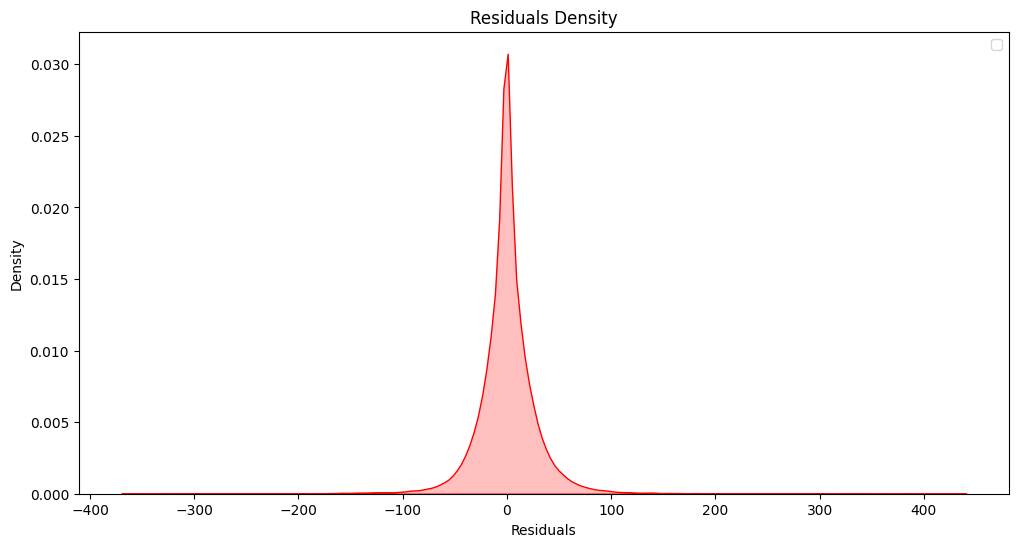

In [27]:
# Calculate the residuals of SARIMA model
residuals_sarima = time_series_data - predictions_sarima

# Plotting the residuals of SARIMA model
plt.figure(figsize=(12, 6))
plt.plot(model_sarima_fit.resid, color='blue')
plt.title('Residuals of SARIMA Model')
plt.xlabel('Time Steps')
plt.ylabel('Residuals')
plt.show()

# Plotting the residuals density
plt.figure(figsize=(12, 6))
sns.kdeplot(residuals_sarima, color='red', shade=True)
plt.title('Residuals Density')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.legend()
plt.show()

In [28]:
from sklearn.metrics import explained_variance_score  # Import the missing function

# Calculate Mean Absolute Error (MAE) for SARIMA
mae_sarima = mean_absolute_error(time_series_data, predictions_sarima)
print(f"Mean Absolute Error (MAE) for SARIMA: {mae_sarima}")
# Calculate Mean Squared Error (MSE) for SARIMA
mse_sarima = mean_squared_error(time_series_data, predictions_sarima)
print(f"Mean Squared Error (MSE) for SARIMA: {mse_sarima}")
# Calculate Root Mean Squared Error (RMSE) for SARIMA
rmse_sarima = np.sqrt(mse_sarima)
print(f"Root Mean Squared Error (RMSE) for SARIMA: {rmse_sarima}")
# Calculate R-Squared for SARIMA
r2_sarima = r2_score(time_series_data, predictions_sarima)
print(f"R-Squared for SARIMA: {r2_sarima}")
# Calculate Mean Absolute Scaled Error (MASE) for SARIMA
mase_sarima = mean_absolute_scaled_error(time_series_data, predictions_sarima, time_series_data[:int(len(time_series_data) * 0.7)])
print(f"Mean Absolute Scaled Error (MASE) for SARIMA: {mase_sarima}")
# Calculate Explained Variance Score for SARIMA
evs_sarima = explained_variance_score(time_series_data, predictions_sarima)
print(f"Explained Variance Score for SARIMA: {evs_sarima}")

Mean Absolute Error (MAE) for SARIMA: 6.735659227598636
Mean Squared Error (MSE) for SARIMA: 121.65317066330479
Root Mean Squared Error (RMSE) for SARIMA: 11.029649616524761
R-Squared for SARIMA: 0.9795948382322902
Mean Absolute Scaled Error (MASE) for SARIMA: 0.9181376336412358
Explained Variance Score for SARIMA: 0.9795948466776292


In [29]:
# Now perform Arch and Garch models
from arch import arch_model

# Define the GARCH model
model_garch = arch_model(time_series_data, vol='Garch', p=1, q=1)

# Fit the GARCH model
model_garch_fit = model_garch.fit()

# Model Summary
model_garch_fit.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 25595922.990727257
Iteration:      2,   Func. Count:     12,   Neg. LLF: 537267.475266647
Iteration:      3,   Func. Count:     19,   Neg. LLF: 426241.31496394606
Iteration:      4,   Func. Count:     25,   Neg. LLF: 471187.4518613293
Iteration:      5,   Func. Count:     31,   Neg. LLF: 404336.81555881316
Iteration:      6,   Func. Count:     37,   Neg. LLF: 402987.6946555791
Iteration:      7,   Func. Count:     43,   Neg. LLF: 402404.50666081085
Iteration:      8,   Func. Count:     48,   Neg. LLF: 405304.75697563565
Iteration:      9,   Func. Count:     54,   Neg. LLF: 402256.8302398443
Iteration:     10,   Func. Count:     59,   Neg. LLF: 402245.65952624165
Iteration:     11,   Func. Count:     64,   Neg. LLF: 402245.59456059645
Iteration:     12,   Func. Count:     69,   Neg. LLF: 402245.59256447636
Iteration:     13,   Func. Count:     74,   Neg. LLF: 402245.5925217739
Iteration:     14,   Func. Count:     79,   Neg. LLF: 402

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:     Number of Sunspots   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -402246.
Distribution:                  Normal   AIC:                           804499.
Method:            Maximum Likelihood   BIC:                           804536.
                                        No. Observations:                75665
Date:                Mon, Apr 28 2025   Df Residuals:                    75664
Time:                        15:33:31   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            27.9439      0.970     28.817 1.306e-182 [ 26.043, 29.844]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega         90.3005      7.572     11.925  8.743e-33 [ 75.459,1.051e+02]
alpha[1]       0.6101  1.574e-02     38.767      0.000   [  0.579,  0.641]
beta[1]        0.3899  1.797e-02     21.697 2.205e-104   [  0.355,  0.425]
==========================================================================

Covariance estimator: robust
"""

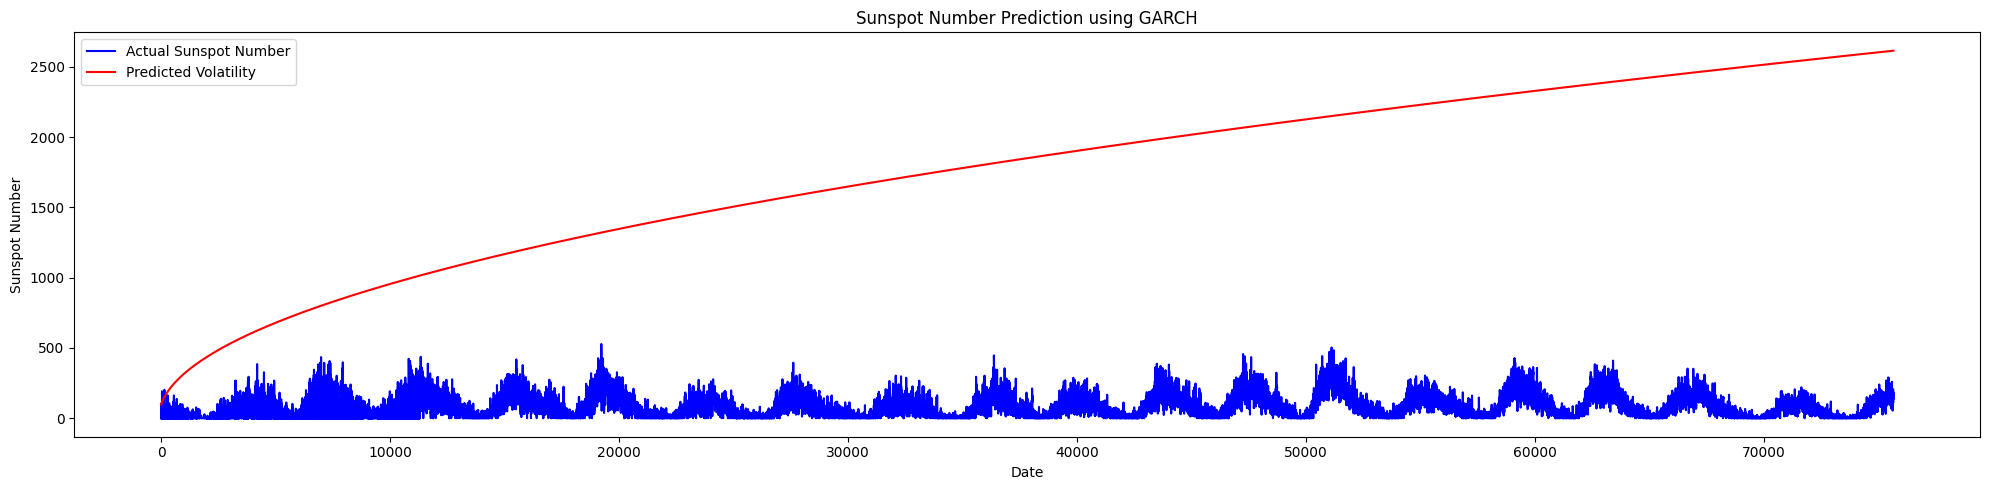

In [35]:
# Make predictions
predictions_garch = model_garch_fit.forecast(horizon=len(time_series_data))
forecasted_volatility = np.sqrt(predictions_garch.variance.values[-1, :])

plt.figure(figsize=(20, 5))
plt.plot(time_series_data.index,
         time_series_data,
         label='Actual Sunspot Number',
         color='blue')
plt.plot(time_series_data.index,
         forecasted_volatility,
         label='Predicted Volatility',
         color='red')

plt.title('Sunspot Number Prediction using GARCH')
plt.xlabel('Date')
plt.ylabel('Sunspot Number')
plt.legend()
plt.tight_layout()
plt.show()

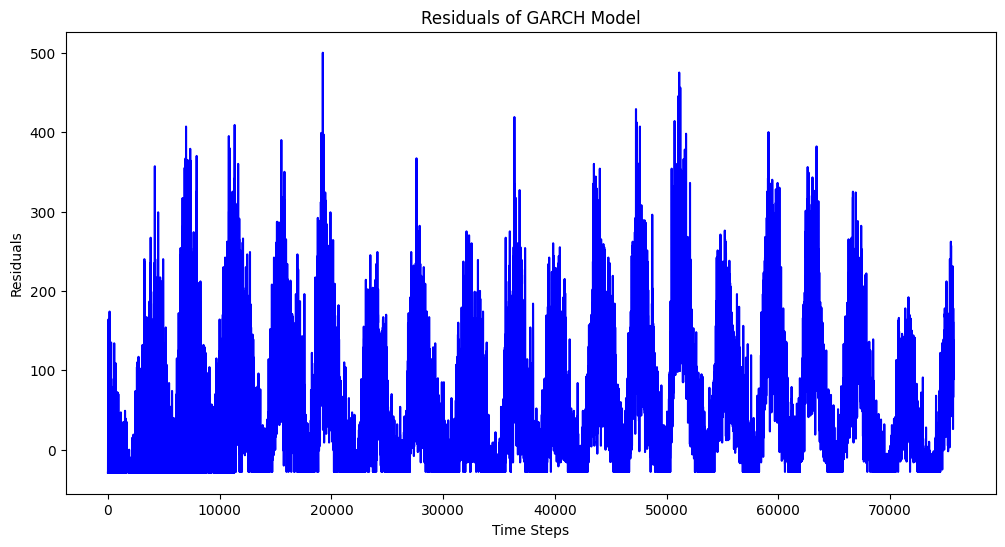

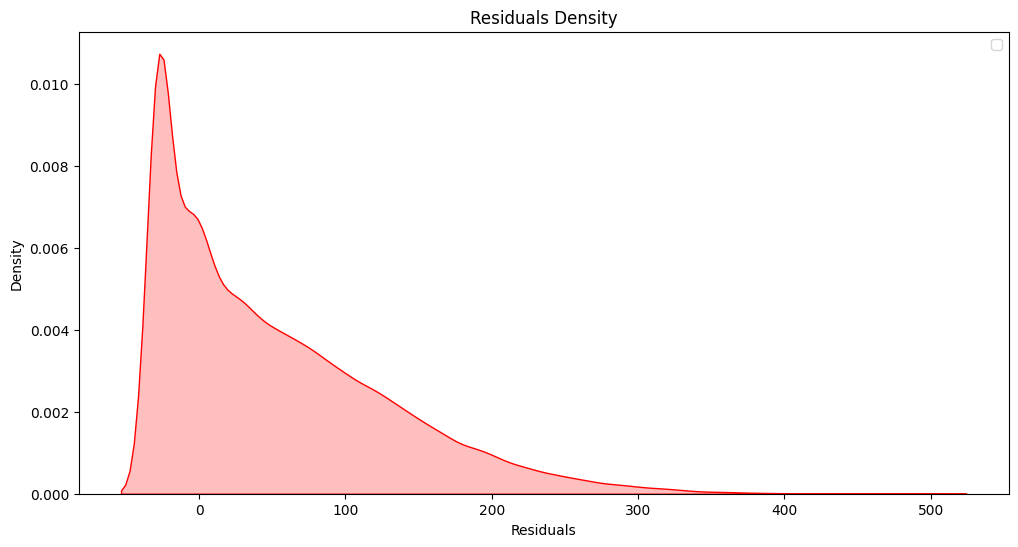

In [31]:
# Calculate the residuals of GARCH model
residuals_garch = model_garch_fit.resid

# Plotting the residuals of GARCH model
plt.figure(figsize=(12, 6))
plt.plot(residuals_garch, color='blue')
plt.title('Residuals of GARCH Model')
plt.xlabel('Time Steps')
plt.ylabel('Residuals')
plt.show()

# Plotting the residuals density
plt.figure(figsize=(12, 6))
sns.kdeplot(residuals_garch, color='red', shade=True)
plt.title('Residuals Density')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.legend()
plt.show()

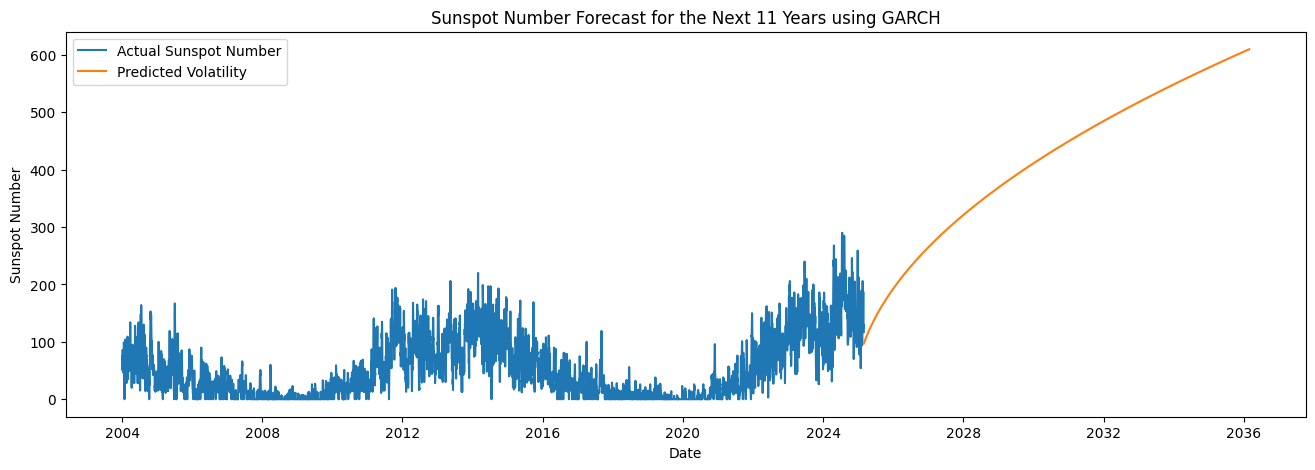

In [37]:
# Forecasting future values using GARCH with forecast for the next 11 years
forecast_period_garch = 4017

# Use forecast to obtain predicted_mean and confidence intervals
forecast_garch = model_garch_fit.forecast(horizon=forecast_period_garch)

# Extract the forecasted volatility
forecasted_volatility_garch = np.sqrt(forecast_garch.variance.values[-1, :])

# Create a date range for the future predictions starting one day after the last date
last_date = filtered_df_arima['Date'].iloc[-1]
future_dates_garch = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_period_garch)

# Create a DataFrame for the future predictions
future_df_garch = pd.DataFrame({'Predicted Volatility': forecasted_volatility_garch}, index=future_dates_garch)

# Plot the actual data and the GARCH forecast
plt.figure(figsize=(16, 5))
sns.lineplot(data=filtered_df_arima, x='Date', y='Number of Sunspots', label='Actual Sunspot Number')
sns.lineplot(x=future_df_garch.index, y=future_df_garch['Predicted Volatility'], label='Predicted Volatility')
plt.title('Sunspot Number Forecast for the Next 11 Years using GARCH')
plt.xlabel('Date')
plt.ylabel('Sunspot Number')
plt.legend()
plt.show()

In [38]:
# Calculate Mean Absolute Error (MAE) for GARCH
mae_garch = mean_absolute_error(time_series_data, forecasted_volatility)

# Calculate Mean Squared Error (MSE) for GARCH
mse_garch = mean_squared_error(time_series_data, forecasted_volatility)

# Calculate Root Mean Squared Error (RMSE) for GARCH
rmse_garch = np.sqrt(mse_garch)

# Calculate R-Squared for GARCH
r2_garch = r2_score(time_series_data, forecasted_volatility)

# Calculate Mean Absolute Scaled Error (MASE) for GARCH
# Ensure train_size is defined
train_size = int(len(time_series_data) * 0.7)  # 70% of the data for training
mase_garch = mean_absolute_scaled_error(time_series_data, forecasted_volatility, time_series_data[:train_size])

# Calculate Explained Variance Score for GARCH
evs_garch = explained_variance_score(time_series_data, forecasted_volatility)

# Print the evaluation metrics for GARCH
print('Evaluation Metrics for GARCH Model')
print('---------------------------------------------------')
print(f'Mean Absolute Error (MAE) for GARCH: {mae_garch}')
print(f'Mean Squared Error (MSE) for GARCH: {mse_garch}')
print(f'Root Mean Squared Error (RMSE) for GARCH: {rmse_garch}')
print(f'R-Squared for GARCH: {r2_garch}')
print(f'Mean Absolute Scaled Error (MASE) for GARCH: {mase_garch}')
print(f'Explained Variance Score for GARCH: {evs_garch}')

Evaluation Metrics for GARCH Model
---------------------------------------------------
Mean Absolute Error (MAE) for GARCH: 1666.8778766528526
Mean Squared Error (MSE) for GARCH: 3147466.7802479886
Root Mean Squared Error (RMSE) for GARCH: 1774.1101375754517
R-Squared for GARCH: -526.931729680971
Mean Absolute Scaled Error (MASE) for GARCH: 82.2087965418218
Explained Variance Score for GARCH: -60.893484516171995


In [39]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Prepare the data for Holt-Winters
# Use the 'Number of Sunspots' column as the time series data
time_series_data_hw = filtered_df['Number of Sunspots']

# Split the data into train and test sets
train_size_hw = int(len(time_series_data_hw) * 0.8)
train_data_hw = time_series_data_hw[:train_size_hw]
test_data_hw = time_series_data_hw[train_size_hw:]

# Fit the Holt-Winters model
hw_model = ExponentialSmoothing(train_data_hw, seasonal='add', seasonal_periods=12).fit()

# Model Summary
hw_model.summary()

NameError: name 'filtered_df' is not defined

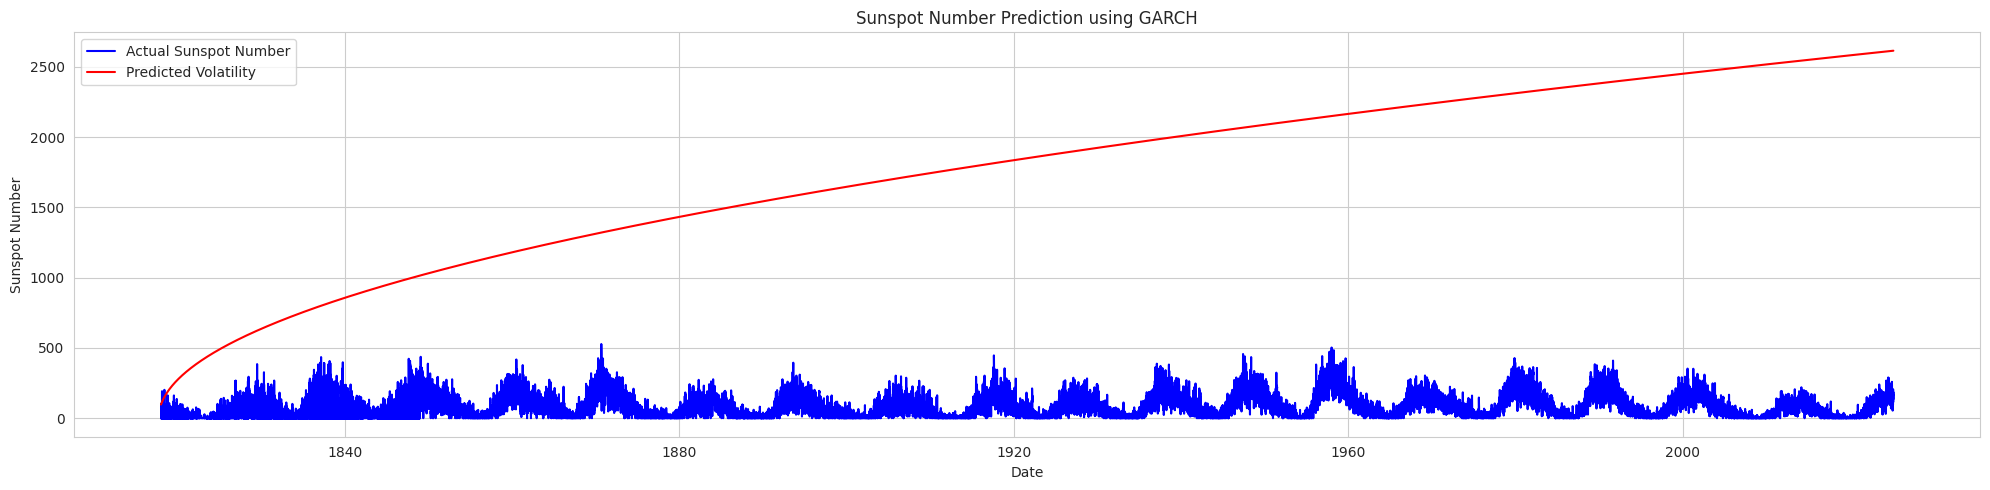

In [ ]:
# Make predictions
predictions_garch = model_garch_fit.forecast(horizon=len(time_series_data))

# Extract the forecasted volatility
forecasted_volatility = np.sqrt(predictions_garch.variance.values[-1, :])

# Plot the actual and predicted values
plt.figure(figsize=(20, 5))

# Plot actual values
plt.plot(df['Date'], time_series_data, label='Actual Sunspot Number', color='blue')

# Plot predicted values
plt.plot(df['Date'], forecasted_volatility, label='Predicted Volatility', color='red')

# Set plot title and labels
plt.title('Sunspot Number Prediction using GARCH')
plt.xlabel('Date')
plt.ylabel('Sunspot Number')
plt.legend()
plt.tight_layout()
plt.show()

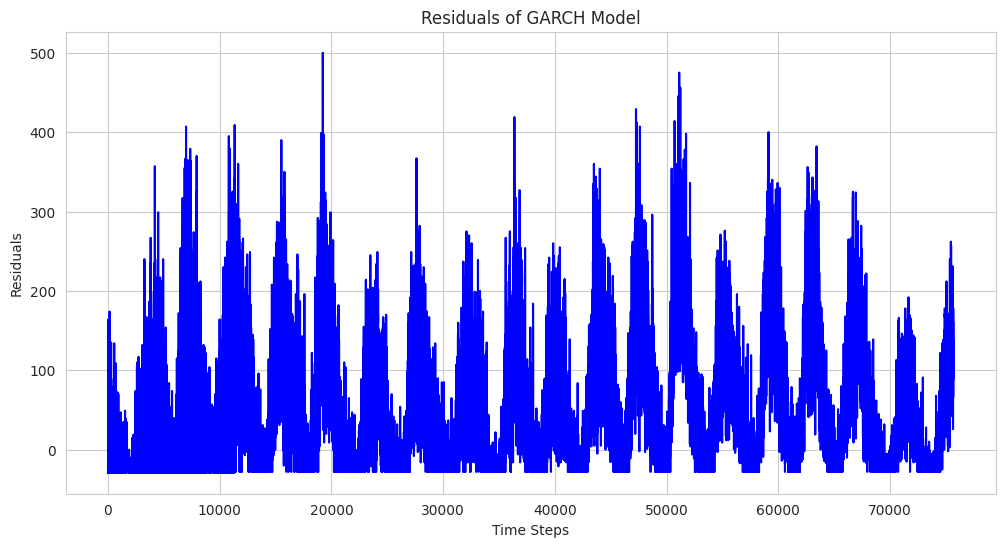

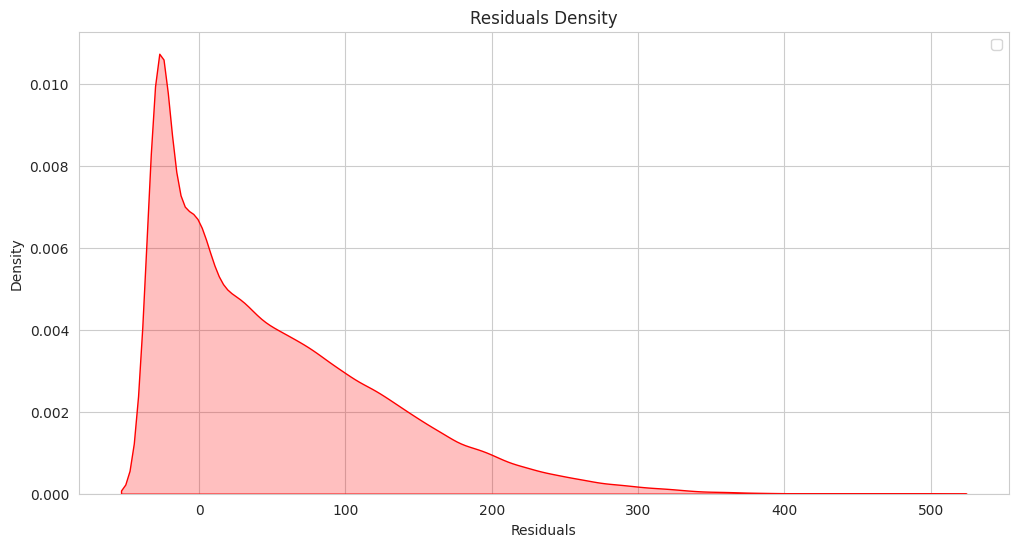

In [ ]:
# Calculate the residuals of GARCH model
residuals_garch = model_garch_fit.resid

# Plotting the residuals of GARCH model
plt.figure(figsize=(12, 6))
plt.plot(residuals_garch, color='blue')
plt.title('Residuals of GARCH Model')
plt.xlabel('Time Steps')
plt.ylabel('Residuals')
plt.show()

# Plotting the residuals density
plt.figure(figsize=(12, 6))
sns.kdeplot(residuals_garch, color='red', shade=True)
plt.title('Residuals Density')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.legend()
plt.show()

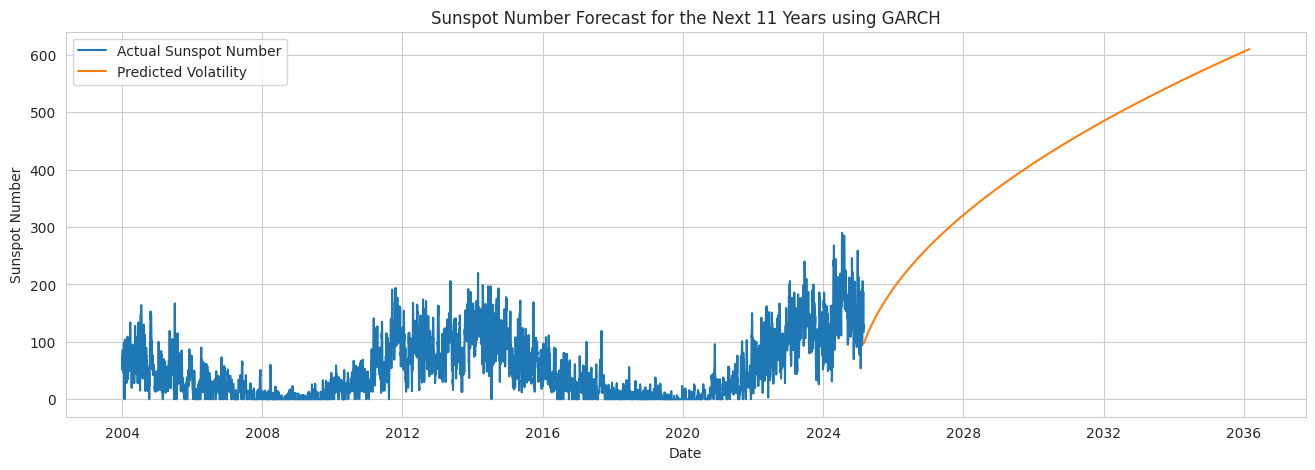

In [ ]:
# Forecasting future values using GARCH with forecast for the next 11 years
forecast_period_garch = 4017  # 11 years (assuming daily data)

# Use forecast to obtain predicted_mean and confidence intervals
forecast_garch = model_garch_fit.forecast(horizon=forecast_period_garch)

# Extract the forecasted volatility
forecasted_volatility_garch = np.sqrt(forecast_garch.variance.values[-1, :])

# Create a date range for the future predictions starting one day after the last date
last_date = df['Date'].iloc[-1]
future_dates_garch = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_period_garch)

# Create a DataFrame for the future predictions
future_df_garch = pd.DataFrame({'Predicted Volatility': forecasted_volatility_garch}, index=future_dates_garch)

# Plot the actual data and the GARCH forecast
plt.figure(figsize=(16, 5))
sns.lineplot(data=filtered_df, x='Date', y='Number of Sunspots', label='Actual Sunspot Number')
sns.lineplot(x=future_df_garch.index, y=future_df_garch['Predicted Volatility'], label='Predicted Volatility')
plt.title('Sunspot Number Forecast for the Next 11 Years using GARCH')
plt.xlabel('Date')
plt.ylabel('Sunspot Number')
plt.legend()
plt.show()

In [ ]:
# Calculate Mean Absolute Error (MAE) for GARCH
mae_garch = mean_absolute_error(time_series_data, forecasted_volatility)

# Calculate Mean Squared Error (MSE) for GARCH
mse_garch = mean_squared_error(time_series_data, forecasted_volatility)

# Calculate Root Mean Squared Error (RMSE) for GARCH
rmse_garch = np.sqrt(mse_garch)

# Calculate R-Squared for GARCH
r2_garch = r2_score(time_series_data, forecasted_volatility)

# Calculate Mean Absolute Scaled Error (MASE) for GARCH
mase_garch = mean_absolute_scaled_error(time_series_data, forecasted_volatility, time_series_data[:train_size])

# Calculate Explained Variance Score for GARCH
evs_garch = explained_variance_score(time_series_data, forecasted_volatility)

# Print the evaluation metrics for GARCH
print('Evaluation Metrics for GARCH Model')
print('---------------------------------------------------')
print(f'Mean Absolute Error (MAE) for GARCH: {mae_garch}')
print(f'Mean Squared Error (MSE) for GARCH: {mse_garch}')
print(f'Root Mean Squared Error (RMSE) for GARCH: {rmse_garch}')
print(f'R-Squared for GARCH: {r2_garch}')
print(f'Mean Absolute Scaled Error (MASE) for GARCH: {mase_garch}')
print(f'Explained Variance Score for GARCH: {evs_garch}')

Evaluation Metrics for GARCH Model
---------------------------------------------------
Mean Absolute Error (MAE) for GARCH: 1666.938429314387
Mean Squared Error (MSE) for GARCH: 3147694.565645193
Root Mean Squared Error (RMSE) for GARCH: 1774.1743334985977
R-Squared for GARCH: -526.9699366414056
Mean Absolute Scaled Error (MASE) for GARCH: 86.36351407178157
Explained Variance Score for GARCH: -60.89783105553168


In [41]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Prepare the data for Holt-Winters
# Use the 'Number of Sunspots' column as the time series data
time_series_data_hw = filtered_df_arima['Number of Sunspots']

# Split the data into train and test sets
train_size_hw = int(len(time_series_data_hw) * 0.8)
train_data_hw = time_series_data_hw[:train_size_hw]
test_data_hw = time_series_data_hw[train_size_hw:]

# Fit the Holt-Winters model
hw_model = ExponentialSmoothing(train_data_hw, seasonal='add', seasonal_periods=12).fit()

# Model Summary
hw_model.summary()

Dep. Variable:,Number of Sunspots,No. Observations:,6184
Model:,ExponentialSmoothing,SSE,796796.847
Optimized:,True,AIC,30073.795
Trend:,None,BIC,30168.011
Seasonal:,Additive,AICC,30073.884
Seasonal Periods:,12,Date:,"Mon, 28 Apr 2025"
Box-Cox:,False,Time:,15:40:13
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9722478,alpha,True
smoothing_seasonal,0.0269564,gamma,True


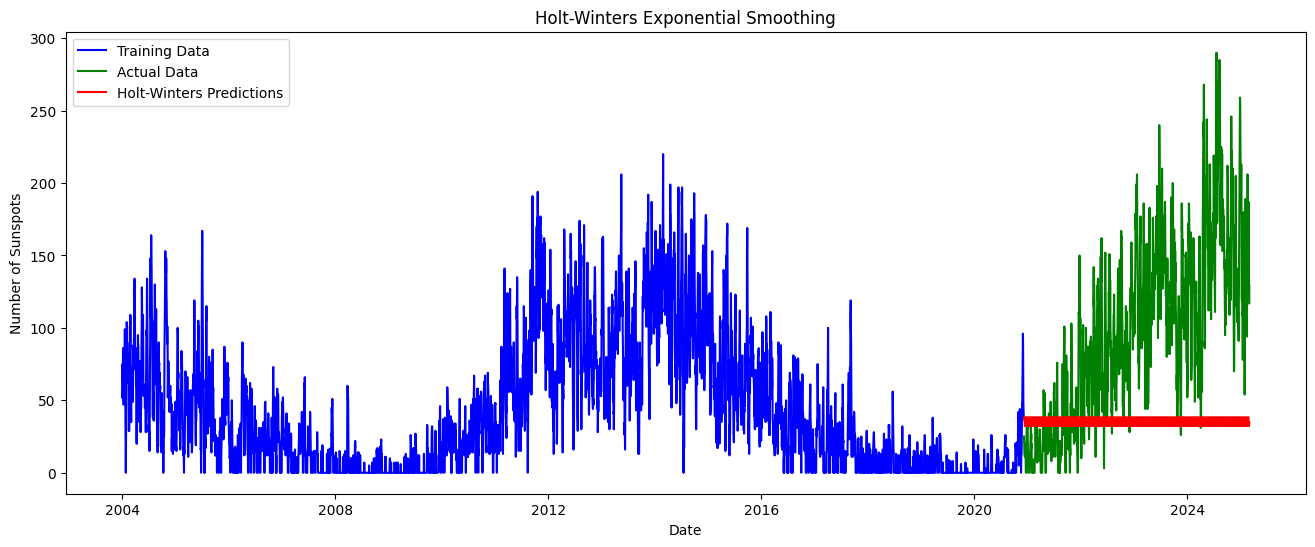

In [43]:
# Make predictions
hw_predictions = hw_model.forecast(len(test_data_hw))

# Plot the actual and predicted values
plt.figure(figsize=(16, 6))
plt.plot(filtered_df_arima['Date'][:train_size_hw], train_data_hw, label='Training Data', color='blue')
plt.plot(filtered_df_arima['Date'][train_size_hw:], test_data_hw, label='Actual Data', color='green')
plt.plot(filtered_df_arima['Date'][train_size_hw:], hw_predictions, label='Holt-Winters Predictions', color='red')
plt.title('Holt-Winters Exponential Smoothing')
plt.xlabel('Date')
plt.ylabel('Number of Sunspots')
plt.legend()
plt.show()

In [44]:
# Calculate Mean Absolute Error (MAE) for Holt-Winters
mae_hw = mean_absolute_error(test_data_hw, hw_predictions)

# Calculate Mean Squared Error (MSE) for Holt-Winters
mse_hw = mean_squared_error(test_data_hw, hw_predictions)

# Calculate Root Mean Squared Error (RMSE) for Holt-Winters
rmse_hw = np.sqrt(mse_hw)

# Calculate R-Squared for Holt-Winters
r2_hw = r2_score(test_data_hw, hw_predictions)

# Calculate Explained Variance Score for Holt-Winters
evs_hw = explained_variance_score(test_data_hw, hw_predictions)

# Print the evaluation metrics for Holt-Winters
print('Evaluation Metrics for Holt-Winters Model')
print('---------------------------------------------------')
print(f'Mean Absolute Error (MAE) for Holt-Winters: {mae_hw}')
print(f'Mean Squared Error (MSE) for Holt-Winters: {mse_hw}')
print(f'Root Mean Squared Error (RMSE) for Holt-Winters: {rmse_hw}')
print(f'R-Squared for Holt-Winters: {r2_hw}')
print(f'Explained Variance Score for Holt-Winters: {evs_hw}')

Evaluation Metrics for Holt-Winters Model
---------------------------------------------------
Mean Absolute Error (MAE) for Holt-Winters: 70.69927756145194
Mean Squared Error (MSE) for Holt-Winters: 7798.1983670792815
Root Mean Squared Error (RMSE) for Holt-Winters: 88.30740833632976
R-Squared for Holt-Winters: -1.036169391479394
Explained Variance Score for Holt-Winters: -0.0006705275326364113
